# Preparing data for the model

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, make_scorer


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline



In [21]:
FILE_PATH = './data/pickles/02_tokenized_descriptions.pkl'

data = pd.read_pickle(FILE_PATH)
data

,description,variety,desc_clean
0,This tremendous 100% varietal wine hails from ...,Cabernet Sauvignon,tremend 100% variet wine hail oakvill age thre...
1,Mac Watson honors the memory of a wine once ma...,Sauvignon Blanc,mac watson honor memori wine made mother treme...
2,"This spent 20 months in 30% new French oak, an...",Pinot Noir,spent 20 month 30% new french oak incorpor fru...
3,This re-named vineyard was formerly bottled as...,Pinot Noir,name vineyard former bottl delancellotti find ...
4,The producer sources from two blocks of the vi...,Pinot Noir,produc sourc two block vineyard wine one high ...
...,...,...,...
64728,"This needs a good bit of breathing time, then ...",Pinot Noir,need good bit breath time begin reveal cherri ...
64729,The nose is dominated by the attractive scents...,Pinot Noir,nose domin attract scent new french oak hint p...
64730,"Decades ago, Beringer’s then-winemaker Myron N...",White Blend,decad ago bering winemak myron nightingal crea...
64731,Many people feel Fiano represents southern Ita...,White Blend,mani peopl feel fiano repres southern itali pr...


**Before fitting data into the model, let's check the variety distribution once again**

In [22]:
data.variety.value_counts()

Pinot Noir                  9283
Chardonnay                  9159
Cabernet Sauvignon          8267
Red Blend                   6484
Bordeaux-style Red Blend    5170
Sauvignon Blanc             4034
Syrah                       3662
Riesling                    3582
Merlot                      3176
Zinfandel                   2408
Sangiovese                  2152
Malbec                      1967
Rosé                        1910
White Blend                 1857
Tempranillo                 1622
Name: variety, dtype: int64

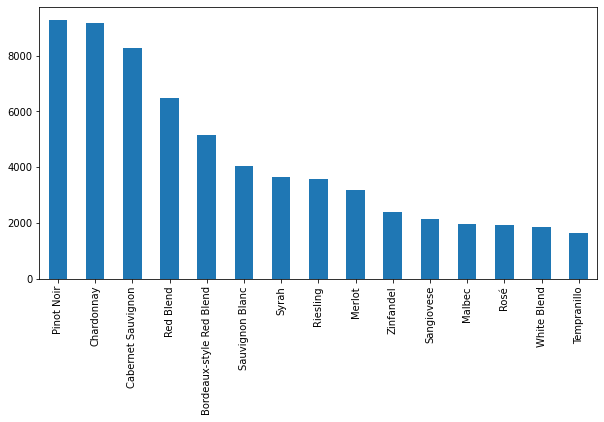

In [23]:
fig = plt.figure(figsize=(10,5))
data.variety.value_counts().plot.bar(ylim=0)

## Train test split

**Originally I vectorized the "desc_clean" field before "train_test_split" step which is wrong. If we are dealing with new data we need to take care of the words which do not appear in the training data 
set**

(notebook 3_Modeling - now moved to the reference folder "notebooks")


In [24]:
# commented cell with the description vectorizing step.


# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# input_data = vectorizer.fit_transform(data.desc_clean)

# # if check of the input_data is needed
# # pd.DataFrame(input_data.toarray(), columns=vectorizer.get_feature_names())

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data.desc_clean, data.variety, test_size = 0.2, random_state = 42)

**Now is the right time to vectorize the data**

Additionally when applying vectorizer on the test dataset, a "transform" method needs to be used.

The CountVectorizer has already been fitted with the training data. So for our test data, we want to call transform(), not fit_transform().

**Otherwise, if we use fit_transform() again on our test data, we'll get different columns based on the unique vocabulary of the test data and Python will throw an error: Dimension Mismatch**

In [26]:
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [27]:
# printing X_train and X_test shapes just to confirm dimensions

print(X_train.shape)
print(X_test.shape)

(51786, 16373)
(12947, 16373)


# Modelling

## Finding the right estimator



To find the right algorithm to our problem, we are going to use some help from Scikit Learn cheat-sheet (below)


In [28]:
from IPython.display import Image

Image(url='https://scikit-learn.org/stable/_static/ml_map.png')

We are going to use:
* Naive Bayes
* Linear SVM
* SVM 
* and one of the Ensemble Classifier - Random Forest

We're going to fine tune the models as best as possible and choose the one with the highest accuracy.

## Baseline models

Let's start our prediction with Naive Bayes model as the baseline. Additionally let's create a function which allow us to evaluate trained models quickly.

In [29]:
# function to evalute models on the test set
def evaluate_model(model, X_test = X_test, y_test = y_test):
    y_pred = model.predict(X_test)
        
    print(classification_report(y_test, y_pred))


### Multinomial Naive Bayes Baseline

In [30]:
%%time

multinomial_NB_base = MultinomialNB()

multinomial_NB_base.fit(X_train,y_train)
evaluate_model(multinomial_NB_base)

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.64      0.69      0.66      1033
      Cabernet Sauvignon       0.54      0.72      0.61      1583
              Chardonnay       0.81      0.89      0.85      1880
                  Malbec       0.41      0.36      0.38       390
                  Merlot       0.61      0.21      0.31       683
              Pinot Noir       0.77      0.77      0.77      1914
               Red Blend       0.55      0.68      0.61      1292
                Riesling       0.83      0.83      0.83       694
                    Rosé       0.79      0.65      0.71       356
              Sangiovese       0.68      0.48      0.56       396
         Sauvignon Blanc       0.77      0.71      0.74       806
                   Syrah       0.75      0.44      0.55       720
             Tempranillo       0.40      0.49      0.44       352
             White Blend       0.81      0.55      0.65       365
         

### Support Vector Machines Baseline

In [73]:
%%time

svm_base = SVC()

svm_base.fit(X_train,y_train)
evaluate_model(svm_base)

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.78      0.75      0.76      1033
      Cabernet Sauvignon       0.58      0.81      0.67      1583
              Chardonnay       0.79      0.94      0.86      1880
                  Malbec       0.67      0.44      0.53       390
                  Merlot       0.86      0.44      0.58       683
              Pinot Noir       0.75      0.84      0.79      1914
               Red Blend       0.67      0.68      0.68      1292
                Riesling       0.86      0.82      0.84       694
                    Rosé       0.82      0.74      0.78       356
              Sangiovese       0.73      0.53      0.61       396
         Sauvignon Blanc       0.82      0.73      0.77       806
                   Syrah       0.80      0.56      0.66       720
             Tempranillo       0.51      0.43      0.47       352
             White Blend       0.85      0.58      0.69       365
         

### Linear Support Vector Machines

With linear SVM we're getting a Convergence Warning: "Liblinear failed to converge, increase the number of iterations...". According to the LinearSVM documentation:

"dual : bool, default=True
    Select the algorithm to either solve the dual or primal
    optimization problem. Prefer dual=False when n_samples > n_features."
    
Let's check shape of the training dataset.

In [70]:
X_train.shape

(51786, 17818)

In our case the number of n_samples (rows in the training dataset = 51786 ) is bigger than n_features (number of columns = 17818), so let's set dual to False.

In [72]:
%%time

linear_svm_base = LinearSVC(dual=False)

linear_svm_base.fit(X_train,y_train)
evaluate_model(linear_svm_base)

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.70      0.71      0.71      1033
      Cabernet Sauvignon       0.65      0.69      0.67      1583
              Chardonnay       0.83      0.87      0.85      1880
                  Malbec       0.46      0.45      0.45       390
                  Merlot       0.56      0.48      0.52       683
              Pinot Noir       0.77      0.80      0.79      1914
               Red Blend       0.67      0.65      0.66      1292
                Riesling       0.81      0.82      0.82       694
                    Rosé       0.70      0.72      0.71       356
              Sangiovese       0.58      0.58      0.58       396
         Sauvignon Blanc       0.75      0.73      0.74       806
                   Syrah       0.66      0.60      0.63       720
             Tempranillo       0.51      0.47      0.49       352
             White Blend       0.70      0.56      0.63       365
         

### Random Forest

In [74]:
%%time

random_forest_base = RandomForestClassifier()

random_forest_base.fit(X_train,y_train)
evaluate_model(random_forest_base)

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.70      0.72      0.71      1033
      Cabernet Sauvignon       0.53      0.81      0.64      1583
              Chardonnay       0.69      0.97      0.81      1880
                  Malbec       0.75      0.29      0.42       390
                  Merlot       0.84      0.38      0.53       683
              Pinot Noir       0.67      0.83      0.74      1914
               Red Blend       0.63      0.67      0.65      1292
                Riesling       0.90      0.72      0.80       694
                    Rosé       0.81      0.63      0.71       356
              Sangiovese       0.84      0.34      0.48       396
         Sauvignon Blanc       0.83      0.68      0.75       806
                   Syrah       0.89      0.48      0.63       720
             Tempranillo       0.63      0.19      0.29       352
             White Blend       0.98      0.33      0.49       365
         

### Baseline Models Summary

Without any significant effort, predicting the grape variety on blank classifiers, we got **accuracy** results as follows:
1. Multinomial Naive Bayes = 0.67
2. Support Vector Machines = 0.74
3. Linear SVM = 0.71
4. Random Forest = 0.69

**We got the best results from SVM**

What needs to be noticed that the SVM was the most time consuming model to train and evaluate. It took us more than 11 minutes. Compared to the rest of the models it was significantly harder to train:
1. Naive Bayes = 584 ms
2. Linear SVM = 57.7 sec
3. Random Forest = 2 min 33 sec


## Models Fine Tuning

### Multinomial Naive Bayes

#### Multinomial Naive Bayes with alpha GridSearch

In [93]:
%%time
# Let's tune up the NB model by searching for better alpha parameter 

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(X_train,y_train)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

evaluate_model(multinomial_nb_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished


Train Accuracy : 0.749
Test Accuracy : 0.676
Best Accuracy Through Grid Search : 0.681
Best Parameters :  {'alpha': 0.5}
                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.63      0.69      0.66      1033
      Cabernet Sauvignon       0.59      0.66      0.62      1583
              Chardonnay       0.84      0.86      0.85      1880
                  Malbec       0.38      0.42      0.40       390
                  Merlot       0.54      0.31      0.39       683
              Pinot Noir       0.81      0.74      0.77      1914
               Red Blend       0.59      0.63      0.61      1292
                Riesling       0.82      0.84      0.83       694
                    Rosé       0.74      0.74      0.74       356
              Sangiovese       0.58      0.57      0.58       396
         Sauvignon Blanc       0.75      0.74      0.75       806
                   Syrah       0.67      0.48      0.56       720
             Tempran

Well, the accuracy slightly went up, but it is still far less than with other models baselines. Let's try to transform our vectorized count matrix to a normalized Term Frequency representation.


#### Multinomial Naive Bayes with TfidfTransformer

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [108]:
%%time

pipeline = Pipeline([('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

tuned_parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0, ]   
}

multinomial_nb_tfidf = GridSearchCV(pipeline, param_grid=tuned_parameters, cv=5, verbose=True)#, n_jobs=-1, cv=2, verbose=True)
multinomial_nb_tfidf.fit(X_train, y_train)

print('Train Accuracy : %.3f'%multinomial_nb_tfidf.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%multinomial_nb_tfidf.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_tfidf.best_score_)
print('Best Parameters : ',multinomial_nb_tfidf.best_params_)

evaluate_model(multinomial_nb_tfidf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   29.5s finished


Train Accuracy : 0.761
Test Accuracy : 0.660
Best Accuracy Through Grid Search : 0.663
Best Parameters :  {'clf__alpha': 0.01, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.68      0.67      0.67      1033
      Cabernet Sauvignon       0.49      0.75      0.59      1583
              Chardonnay       0.77      0.92      0.84      1880
                  Malbec       0.44      0.31      0.36       390
                  Merlot       0.65      0.14      0.24       683
              Pinot Noir       0.72      0.80      0.76      1914
               Red Blend       0.55      0.68      0.60      1292
                Riesling       0.87      0.75      0.81       694
                    Rosé       0.81      0.59      0.69       356
              Sangiovese       0.71      0.42      0.53       396
         Sauvignon Blanc       0.79      0.65      0.72       806
                   Syrah       0.7

Not very useful. **The accuracy actually dropped to 0.66.**

### SVM

We're going to leave the training of this model as a final stage of the models fine tuning.
The time needed for training is approximately 40 hours
Fitting 5 folds for each of 48 candidates, totaling 240 fits with at least 11 minutes each.
Our project is weeks overdue and we don't want to waste more time. However we're going to put the code here for a reference purpose.


In [111]:
# let's search for the best parameters for SVM

# * we're going to leave the training of this model as a final stage of the models fine tuning.
# The time needed for training is approximately 40 hours
# Fitting 5 folds for each of 48 candidates, totalling 240 fits with at least 11 minutes each.
# Our project is weeks overdue and we don't want to waste more time. However we're going to put the code here for a reference purpose.


# pipeline = Pipeline([('svm', SVC())])

# svm_params = {
#     'svm__C' : [0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0 ], 
#     'svm__kernel' : ['linear','rbf','poly'],
#     'svm__class_weight' : ['balanced',None]
# }

# svm_grid = GridSearchCV(pipeline, param_grid=svm_params, cv=5, verbose=True)
# svm_grid.fit(X_train, y_train)

# print('Train Accuracy : %.3f'%svm_grid.best_estimator_.score(X_train, y_train))
# print('Test Accuracy : %.3f'%svm_grid.best_estimator_.score(X_test, y_test))
# print('Best Accuracy Through Grid Search : %.3f'%svm_grid.best_score_)
# print('Best Parameters : ',svm_grid.best_params_)

# evaluate_model(svm_grid)

### Linear SVM

In [124]:
pipeline = Pipeline([('lin_svm', LinearSVC())])

lin_svm_params = {
    'lin_svm__C' : [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0 ],
#     'lin_svm__penalty': ['l1', 'l2'],
#     'lin_svm__loss': ['hinge', 'squared_hinge'],
    'lin_svm__dual' : [False],
#     'lin_svm__multi_class' : ['ovr', 'crammer_singer']
}

lin_svm_grid = GridSearchCV(pipeline, param_grid=lin_svm_params, cv=5, verbose=5)
lin_svm_grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%lin_svm_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%lin_svm_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%lin_svm_grid.best_score_)
print('Best Parameters : ',lin_svm_grid.best_params_)

evaluate_model(lin_svm_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] lin_svm__C=0.01, lin_svm__dual=False ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lin_svm__C=0.01, lin_svm__dual=False, score=0.744, total=   4.0s
[CV] lin_svm__C=0.01, lin_svm__dual=False ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__dual=False, score=0.735, total=   3.9s
[CV] lin_svm__C=0.01, lin_svm__dual=False ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__dual=False, score=0.737, total=   3.7s
[CV] lin_svm__C=0.01, lin_svm__dual=False ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__dual=False, score=0.745, total=   3.7s
[CV] lin_svm__C=0.01, lin_svm__dual=False ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.4s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__dual=False, score=0.736, total=   3.9s
[CV] lin_svm__C=0.1, lin_svm__dual=False .............................
[CV] . lin_svm__C=0.1, lin_svm__dual=False, score=0.735, total=   5.5s
[CV] lin_svm__C=0.1, lin_svm__dual=False .............................
[CV] . lin_svm__C=0.1, lin_svm__dual=False, score=0.726, total=   5.4s
[CV] lin_svm__C=0.1, lin_svm__dual=False .............................
[CV] . lin_svm__C=0.1, lin_svm__dual=False, score=0.731, total=   5.5s
[CV] lin_svm__C=0.1, lin_svm__dual=False .............................
[CV] . lin_svm__C=0.1, lin_svm__dual=False, score=0.745, total=   5.5s
[CV] lin_svm__C=0.1, lin_svm__dual=False .............................
[CV] . lin_svm__C=0.1, lin_svm__dual=False, score=0.731, total=   5.7s
[CV] lin_svm__C=1.0, lin_svm__dual=False .............................
[CV] . lin_svm__C=1.0, lin_svm__dual=False, score=0.699, total=   9.5s
[CV] lin_svm__C=1.0, lin_svm__dual=False .............................
[CV] .

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  lin_svm__C=100.0, lin_svm__dual=False, score=0.627, total= 2.6min
[CV] lin_svm__C=100.0, lin_svm__dual=False ...........................
[CV]  lin_svm__C=100.0, lin_svm__dual=False, score=0.626, total= 2.7min
[CV] lin_svm__C=100.0, lin_svm__dual=False ...........................
[CV]  lin_svm__C=100.0, lin_svm__dual=False, score=0.627, total= 2.7min
[CV] lin_svm__C=100.0, lin_svm__dual=False ...........................
[CV]  lin_svm__C=100.0, lin_svm__dual=False, score=0.638, total= 2.7min
[CV] lin_svm__C=100.0, lin_svm__dual=False ...........................
[CV]  lin_svm__C=100.0, lin_svm__dual=False, score=0.627, total= 2.7min
[CV] lin_svm__C=1000.0, lin_svm__dual=False ..........................
[CV]  lin_svm__C=1000.0, lin_svm__dual=False, score=0.626, total= 2.8min
[CV] lin_svm__C=1000.0, lin_svm__dual=False ..........................
[CV]  lin_svm__C=1000.0, lin_svm__dual=False, score=0.622, total= 2.8min
[CV] lin_svm__C=1000.0, lin_svm__dual=False ........................

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 33.3min finished


Train Accuracy : 0.806
Test Accuracy : 0.741
Best Accuracy Through Grid Search : 0.740
Best Parameters :  {'lin_svm__C': 0.01, 'lin_svm__dual': False}
                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.73      0.74      0.74      1033
      Cabernet Sauvignon       0.64      0.78      0.70      1583
              Chardonnay       0.81      0.93      0.87      1880
                  Malbec       0.59      0.44      0.50       390
                  Merlot       0.75      0.48      0.58       683
              Pinot Noir       0.75      0.85      0.79      1914
               Red Blend       0.70      0.67      0.68      1292
                Riesling       0.85      0.85      0.85       694
                    Rosé       0.81      0.73      0.77       356
              Sangiovese       0.70      0.61      0.65       396
         Sauvignon Blanc       0.80      0.75      0.77       806
                   Syrah       0.75      0.61      0.67 

In [126]:
pipeline = Pipeline([('lin_svm', LinearSVC())])

lin_svm_params = {
    'lin_svm__C' : [0.01, 0.1, 1.0],
#     'lin_svm__penalty': ['l1', 'l2'],
    'lin_svm__loss': ['hinge'],
#     'lin_svm__dual' : [False],
#     'lin_svm__multi_class' : ['ovr', 'crammer_singer']
}

lin_svm_grid = GridSearchCV(pipeline, param_grid=lin_svm_params, cv=5, verbose=5)
lin_svm_grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%lin_svm_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%lin_svm_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%lin_svm_grid.best_score_)
print('Best Parameters : ',lin_svm_grid.best_params_)

evaluate_model(lin_svm_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] lin_svm__C=0.01, lin_svm__loss=hinge ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lin_svm__C=0.01, lin_svm__loss=hinge, score=0.717, total=   1.3s
[CV] lin_svm__C=0.01, lin_svm__loss=hinge ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__loss=hinge, score=0.717, total=   1.3s
[CV] lin_svm__C=0.01, lin_svm__loss=hinge ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__loss=hinge, score=0.714, total=   1.3s
[CV] lin_svm__C=0.01, lin_svm__loss=hinge ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__loss=hinge, score=0.724, total=   1.4s
[CV] lin_svm__C=0.01, lin_svm__loss=hinge ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.4s remaining:    0.0s


[CV]  lin_svm__C=0.01, lin_svm__loss=hinge, score=0.717, total=   1.4s
[CV] lin_svm__C=0.1, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=0.1, lin_svm__loss=hinge, score=0.735, total=   2.9s
[CV] lin_svm__C=0.1, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=0.1, lin_svm__loss=hinge, score=0.730, total=   2.6s
[CV] lin_svm__C=0.1, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=0.1, lin_svm__loss=hinge, score=0.735, total=   2.9s
[CV] lin_svm__C=0.1, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=0.1, lin_svm__loss=hinge, score=0.744, total=   3.3s
[CV] lin_svm__C=0.1, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=0.1, lin_svm__loss=hinge, score=0.732, total=   3.0s
[CV] lin_svm__C=1.0, lin_svm__loss=hinge .............................


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] . lin_svm__C=1.0, lin_svm__loss=hinge, score=0.712, total=   8.6s
[CV] lin_svm__C=1.0, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=1.0, lin_svm__loss=hinge, score=0.705, total=   7.7s
[CV] lin_svm__C=1.0, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=1.0, lin_svm__loss=hinge, score=0.707, total=   7.6s
[CV] lin_svm__C=1.0, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=1.0, lin_svm__loss=hinge, score=0.721, total=   7.6s
[CV] lin_svm__C=1.0, lin_svm__loss=hinge .............................
[CV] . lin_svm__C=1.0, lin_svm__loss=hinge, score=0.709, total=   7.5s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.0min finished


Train Accuracy : 0.842
Test Accuracy : 0.737
Best Accuracy Through Grid Search : 0.735
Best Parameters :  {'lin_svm__C': 0.1, 'lin_svm__loss': 'hinge'}
                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.71      0.76      0.74      1033
      Cabernet Sauvignon       0.67      0.73      0.70      1583
              Chardonnay       0.82      0.92      0.87      1880
                  Malbec       0.55      0.44      0.49       390
                  Merlot       0.69      0.48      0.57       683
              Pinot Noir       0.77      0.84      0.80      1914
               Red Blend       0.70      0.66      0.68      1292
                Riesling       0.83      0.85      0.84       694
                    Rosé       0.74      0.76      0.75       356
              Sangiovese       0.62      0.65      0.63       396
         Sauvignon Blanc       0.80      0.75      0.78       806
                   Syrah       0.71      0.60      0.65

In [127]:
pipeline = Pipeline([('lin_svm', LinearSVC())])

lin_svm_params = {
    'lin_svm__C' : [0.001, 0.01, 0.1, 1.0],
    'lin_svm__penalty': ['l1', 'l2'],
#     'lin_svm__loss': ['hinge'],
    'lin_svm__dual' : [False],
#     'lin_svm__multi_class' : ['ovr', 'crammer_singer']
}

lin_svm_grid = GridSearchCV(pipeline, param_grid=lin_svm_params, cv=5, verbose=5)
lin_svm_grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%lin_svm_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%lin_svm_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%lin_svm_grid.best_score_)
print('Best Parameters : ',lin_svm_grid.best_params_)

evaluate_model(lin_svm_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1, score=0.563, total=   1.3s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1, score=0.556, total=   1.4s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1 ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1, score=0.550, total=   1.3s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1 ......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s


[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1, score=0.565, total=   1.4s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1 ......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.4s remaining:    0.0s


[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l1, score=0.558, total=   1.3s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2 ......
[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2, score=0.705, total=   2.9s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2 ......
[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2, score=0.701, total=   3.0s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2 ......
[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2, score=0.704, total=   3.0s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2 ......
[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2, score=0.712, total=   3.1s
[CV] lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2 ......
[CV]  lin_svm__C=0.001, lin_svm__dual=False, lin_svm__penalty=l2, score=0.703, total=   3.4s
[CV] lin_svm__C=0.01, lin_svm__dual=False, lin_svm__penalty=l1 .......
[CV]  lin_svm__C

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l1, score=0.707, total=  52.5s
[CV] lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l1 ........
[CV]  lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l1, score=0.712, total=  53.8s
[CV] lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l1 ........
[CV]  lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l1, score=0.726, total=  55.2s
[CV] lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l1 ........
[CV]  lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l1, score=0.717, total=  46.9s
[CV] lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l2 ........
[CV]  lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l2, score=0.699, total=   9.4s
[CV] lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l2 ........
[CV]  lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l2, score=0.690, total=   9.4s
[CV] lin_svm__C=1.0, lin_svm__dual=False, lin_svm__penalty=l2 ........
[CV]  lin_svm__C=1.0, lin_sv

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  8.4min finished


Train Accuracy : 0.806
Test Accuracy : 0.741
Best Accuracy Through Grid Search : 0.740
Best Parameters :  {'lin_svm__C': 0.01, 'lin_svm__dual': False, 'lin_svm__penalty': 'l2'}
                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.73      0.74      0.74      1033
      Cabernet Sauvignon       0.64      0.78      0.70      1583
              Chardonnay       0.81      0.93      0.87      1880
                  Malbec       0.59      0.44      0.50       390
                  Merlot       0.75      0.48      0.58       683
              Pinot Noir       0.75      0.85      0.79      1914
               Red Blend       0.70      0.67      0.68      1292
                Riesling       0.85      0.85      0.85       694
                    Rosé       0.81      0.73      0.77       356
              Sangiovese       0.70      0.61      0.65       396
         Sauvignon Blanc       0.80      0.75      0.77       806
                   Syrah      

### Random Forest

In [128]:
pipeline = Pipeline([('forest', RandomForestClassifier())])


forest_params = {
    'forest__max_depth' : [10, 50, 100],
    'forest__n_estimators': [100, 500],
    'forest__min_samples_leaf': [10, 50, 100],
    'forest__class_weight' : ['balanced',None]
}

forest_grid = GridSearchCV(pipeline, param_grid=forest_params, cv=5, verbose=5)
forest_grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%forest_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%forest_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%forest_grid.best_score_)
print('Best Parameters : ',forest_grid.best_params_)

evaluate_model(forest_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100, score=0.635, total=   4.7s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100, score=0.614, total=   4.5s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100, score=0.628, total=   4.4s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s


[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100, score=0.637, total=   4.3s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.9s remaining:    0.0s


[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=100, score=0.634, total=   4.5s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=500 
[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=500, score=0.661, total=  21.4s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=500 
[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=500, score=0.647, total=  20.9s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=500 
[CV]  forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_estimators=500, score=0.647, total=  21.8s
[CV] forest__class_weight=balanced, forest__max_depth=10, forest__min_samples_leaf=10, forest__n_

[CV]  forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=10, forest__n_estimators=500, score=0.658, total= 1.2min
[CV] forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=10, forest__n_estimators=500 
[CV]  forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=10, forest__n_estimators=500, score=0.673, total= 1.2min
[CV] forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=10, forest__n_estimators=500 
[CV]  forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=10, forest__n_estimators=500, score=0.663, total= 1.1min
[CV] forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_estimators=100 
[CV]  forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_estimators=100, score=0.641, total=   9.0s
[CV] forest__class_weight=balanced, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_

[CV]  forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, forest__n_estimators=100, score=0.631, total=   8.5s
[CV] forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, forest__n_estimators=100 
[CV]  forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, forest__n_estimators=100, score=0.632, total=   9.0s
[CV] forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, forest__n_estimators=100 
[CV]  forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, forest__n_estimators=100, score=0.624, total=   8.9s
[CV] forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, forest__n_estimators=100 
[CV]  forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, forest__n_estimators=100, score=0.642, total=   8.9s
[CV] forest__class_weight=balanced, forest__max_depth=100, forest__min_samples_leaf=50, fo

[CV]  forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=100, score=0.448, total=   4.1s
[CV] forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=100 
[CV]  forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=100, score=0.438, total=   4.0s
[CV] forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=500 
[CV]  forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=500, score=0.455, total=  20.3s
[CV] forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=500 
[CV]  forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=500, score=0.451, total=  19.3s
[CV] forest__class_weight=None, forest__max_depth=10, forest__min_samples_leaf=50, forest__n_estimators=500 
[CV]  forest__cl

[CV]  forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_estimators=500, score=0.537, total=  47.3s
[CV] forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_estimators=500 
[CV]  forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_estimators=500, score=0.550, total=  42.5s
[CV] forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_estimators=500 
[CV]  forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=50, forest__n_estimators=500, score=0.542, total=  42.5s
[CV] forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=100, forest__n_estimators=100 
[CV]  forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=100, forest__n_estimators=100, score=0.505, total=   7.0s
[CV] forest__class_weight=None, forest__max_depth=50, forest__min_samples_leaf=100, forest__n_estimators=100 
[CV]  forest_

[CV]  forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=100, score=0.504, total=   6.7s
[CV] forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=100 
[CV]  forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=100, score=0.491, total=   6.7s
[CV] forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=100 
[CV]  forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=100, score=0.498, total=   6.6s
[CV] forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=100 
[CV]  forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=100, score=0.495, total=   6.8s
[CV] forest__class_weight=None, forest__max_depth=100, forest__min_samples_leaf=100, forest__n_estimators=500 


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 70.0min finished


Train Accuracy : 0.694
Test Accuracy : 0.662
Best Accuracy Through Grid Search : 0.665
Best Parameters :  {'forest__class_weight': 'balanced', 'forest__max_depth': 50, 'forest__min_samples_leaf': 10, 'forest__n_estimators': 500}
                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.59      0.74      0.66      1033
      Cabernet Sauvignon       0.80      0.60      0.69      1583
              Chardonnay       0.89      0.77      0.82      1880
                  Malbec       0.45      0.44      0.44       390
                  Merlot       0.65      0.52      0.58       683
              Pinot Noir       0.87      0.63      0.73      1914
               Red Blend       0.70      0.43      0.53      1292
                Riesling       0.67      0.88      0.77       694
                    Rosé       0.51      0.85      0.63       356
              Sangiovese       0.42      0.71      0.53       396
         Sauvignon Blanc       0.72      0.7

# Summary and discussion

Our task was to create a multi-class classifier to predict the wine grape variety based on a review description. We used publicly available dataset, which can be downloaded from Kaggle datasets. We divided our project into three stages i.e.:
1. Data Cleaning,
2. Description Text Preparation,
3. Modeling.

In those stages we've repeated and got familiarized with the Pandas package handful features to process the text data. We've refreshed the common steps for text cleaning tasks and text preparation for modeling (stemming, vectorizing). We got to know the NLTK library better and its usage during the course of the project. Finally we went through the process of modeling, finding the best classifier and ways of their fine tuning. Additionally we structured our project into separate jupyter notebooks and folders to make it more transparent for the future recall. I can add that the notebook called "sandbox" is very important to me as I tested there some solutions which not necessarily were used in the final project notebooks.

**Classifiers**

We've noticed that the classifier with the highest accuracy was SVM. However due to its long training time, we've mainly focused on improving the LinearSVM classifier. What needs to be added that accuracy of all the picked up algorithms were quite similar (at least at the baseline). This observation might suggest that the biggest room fro improvement is in the data.

**What could be done to increase accuracy?**
* adding n-grams: bi-grams or tri-grams,
* perform topic modeling - find 5 or more words describing particular grape variety,
* combine the dataset with other dataset to recognize most common wine colors made out of particular grape variety (red, white, rose),
* use other algorithms like xgboost, neural networks, BERT to increase the accuracy,
* use other ensemble methods like boosting, bagging, stacking

**Summary Scores**

**1. Linear SVM - best score**
Train Accuracy : 0.806
Test Accuracy : 0.741
Best Accuracy Through Grid Search : 0.740
Best Parameters :  {'lin_svm__C': 0.01, 'lin_svm__dual': False, 'lin_svm__penalty': 'l2'}

**2. Multinomial Naive Bayes:**
Train Accuracy : 0.749
Test Accuracy : 0.676
Best Accuracy Through Grid Search : 0.681
Best Parameters :  {'alpha': 0.5}

**3. Random Forest:**
Actually Random Forest predicted the grape varieties better without any hyperparameters tuning. The baseline accuracy score was: **0.69** while the gridsearch results were: 
Train Accuracy : 0.694
Test Accuracy : 0.662
Best Accuracy Through Grid Search : **0.665**
Best Parameters :  {'forest__class_weight': 'balanced', 'forest__max_depth': 50, 'forest__min_samples_leaf': 10, 'forest__n_estimators': 500}

**4. SVM:**
We haven't check the tuning possibilities for SVM properly. The reason for this, is mainly due to lack of time as this project is overdue and SVM classifier trains very long. However I'm going to come back to it and improve the score over the time.

The score of the raw SVM classifier was **0.74**







